# To Run Before Everything Else

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import base64
import json
import time
import sklearn
import imblearn
!pip install category_encoders
import category_encoders
from joblib import dump, load
import os
import zipfile
import lightgbm as lgb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Preprocessing

In [ ]:
# Load the cleaned dataset
with zipfile.ZipFile('../Data/clean_df.zip', 'r') as zip_ref:
    zip_ref.extractall("../Data")
cleaned_df = pd.read_csv('../Data/clean_df.csv')
print("Clean dataset has "+str(cleaned_df.shape[0])+" samples, "+str(cleaned_df.shape[1])+" features.")

In [ ]:
# removing an unnecessary column
cleaned_df = cleaned_df.drop(columns='Unnamed: 0')

In [19]:
#cleaned_df = pd.read_csv('./Dataset/clean_df.csv')

In [20]:
#cleaned_df = cleaned_df.drop(columns=["Unnamed: 0"])

In [ ]:
cleaned_df.dtypes

id_tracks              object
name_tracks            object
popularity_tracks       int64
explicit                int64
danceability          float64
energy                float64
key                     int64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
time_signature          int64
id_artists             object
followers             float64
genres                 object
name_artists           object
popularity_artists      int64
duration_ms_log       float64
year                    int64
month                   int64
day                     int64
dayofweek               int64
weekofyear              int64
dtype: object

<Axes: xlabel='popularity_tracks', ylabel='Count'>

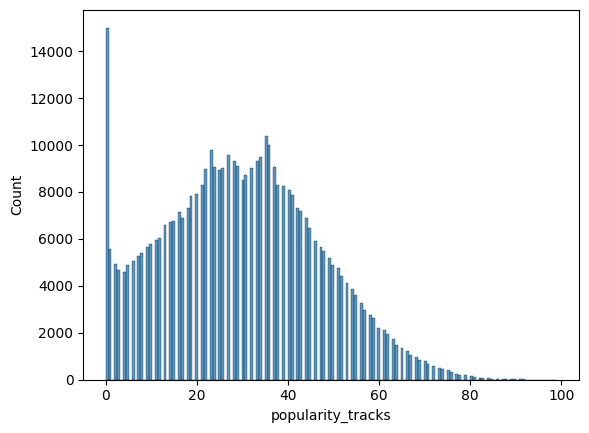

In [ ]:
sns.histplot(cleaned_df, x="popularity_tracks")

Found instances where a song by an artist was repeated multiples times. We will not be removing these duplicates because anyways our ML methods will not be taking into account song names and artist names. We are aiming to rely solely on music features, genres, and follower counts, etc. In addition, the below undersampling and oversampling techniques will be both potentially remove and duplicate these kinds of data points

In [ ]:
cleaned_df[cleaned_df.duplicated(keep=False, subset=["name_tracks", "name_artists"])].sort_values(by=["name_tracks", "name_artists"]).head(200)

,id_tracks,name_tracks,popularity_tracks,explicit,danceability,energy,key,loudness,mode,speechiness,...,followers,genres,name_artists,popularity_artists,duration_ms_log,year,month,day,dayofweek,weekofyear
136273,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",37,0,0.371,0.545,8,-9.315,1,0.0307,...,8157894.0,"irish rock', 'permanent wave', 'rock",U2,82,11.968240,1983,2,28,0,9
136274,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",38,0,0.371,0.545,8,-9.315,1,0.0307,...,8157894.0,"irish rock', 'permanent wave', 'rock",U2,82,11.968240,1983,2,28,0,9
90050,219mhOHU549RFxhslnK52m,"""Móvil"" Oil Special",27,0,0.544,0.629,10,-11.324,1,0.1770,...,240877.0,"cantautor', 'musica andina', 'nueva cancion', ...",Victor Jara,50,12.030731,1969,6,5,3,23
90092,2YXWZExoI7WStafF4vNVZs,"""Móvil"" Oil Special",14,0,0.550,0.652,10,-11.346,1,0.1880,...,240877.0,"cantautor', 'musica andina', 'nueva cancion', ...",Victor Jara,50,12.030927,1969,1,1,2,1
235032,3rG8ZkmKHb4Ms6CsSzEITv,"""The Take Over, The Breaks Over""",59,0,0.609,0.917,9,-2.563,1,0.0477,...,8743699.0,"emo', 'modern rock', 'pop punk",Fall Out Boy,83,12.271800,2007,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,0mvVIlqmAJnk4S1zWz8Pye,(What Did I Do to Be So) Black and Blue,1,0,0.657,0.176,11,-12.539,1,0.0573,...,2256652.0,"adult standards', 'dixieland', 'harlem renaiss...",Louis Armstrong,74,12.141001,1924,1,1,1,1
179950,6THv7c4L5lZmA0H0O2fR7b,(Who Says) You Can't Have It All,44,0,0.579,0.232,2,-12.651,1,0.0261,...,1515343.0,"contemporary country', 'country', 'country road",Alan Jackson,76,12.254039,1992,10,9,4,41
180021,4KJc8lbEOrm5pZMWTSatZ1,(Who Says) You Can't Have It All,28,0,0.579,0.232,2,-12.651,1,0.0261,...,1515343.0,"contemporary country', 'country', 'country road",Alan Jackson,76,12.254039,1992,10,24,5,43
76223,4PEtvlNGnQIU9gJgURUvzR,(Wish I Could) Hideaway,49,0,0.616,0.357,0,-9.911,1,0.0320,...,4202342.0,"album rock', 'classic rock', 'country rock', '...",Creedence Clearwater Revival,81,12.315344,1970,12,7,0,50


In [6]:
duplicate_rows = cleaned_df.duplicated(keep=False, subset=["name_tracks", "name_artists"])
cleaned_df_no_duplicates = cleaned_df[~duplicate_rows]

Distribution of target variable (popularity tracks) looks about the same even with removal of duplicates

<Axes: xlabel='popularity_tracks', ylabel='Count'>

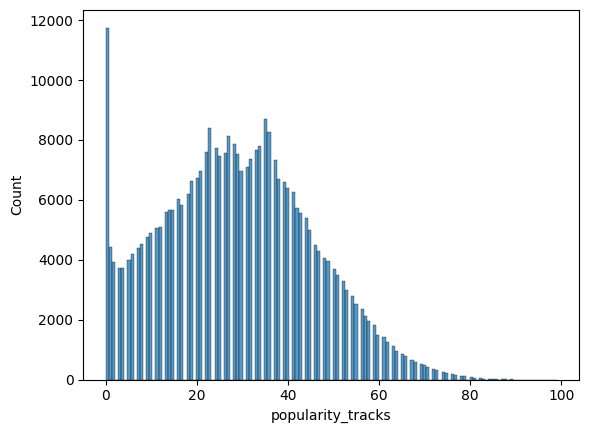

In [7]:
sns.histplot(cleaned_df_no_duplicates, x="popularity_tracks")

In [ ]:
import collections

def genre_transform (genre_string):
  genre_list = genre_string.split(", ")
  genre_list = [s.strip("'") for s in genre_list]
  return tuple(genre_list)

print("Unique genres:", len(np.unique(np.concatenate(cleaned_df['genres'].apply(genre_transform).values))))

genre_column_counts = collections.Counter(set(cleaned_df["genres"].str.replace("'", "").tolist()))
print("Unique combinations of genres:", len(genre_column_counts))

Unique genres: 4407
Unique combinations of genres: 18524


4407 unique genres and 18524 combinations of genres! Target encoding with respect to the popularity tracks may be a good idea in order to get rid of the sparsitity in this multivalued column since most combinations of genres may probably be similar

From the above distribution, there's a pretty steep right skew where after popularity_track 60, row counts start to decrease sharply. Lets apply some thresholding, remove everything greater than popularity 70, and see if this aids in our classication later on

Then lets apply a 70:30 development and test data split with stratifying to sample each popularity track proportionally

In [21]:
dataset = cleaned_df.drop(columns=["id_tracks", "name_tracks", "id_artists", "name_artists"])
dataset = dataset.drop(columns=["energy"])#Based on the correlation matrix from initial EDA
dataset_filtered = dataset[dataset["popularity_tracks"] <= 70]
dataset_features, dataset_y = dataset_filtered.drop(columns=["popularity_tracks"]), dataset_filtered["popularity_tracks"]

dataset_features_dev, dataset_features_test, dataset_y_dev, dataset_y_test = sklearn.model_selection.train_test_split(dataset_features, dataset_y, test_size=0.3, stratify=dataset_y)

In [22]:
# Do a target encoding on genres
encoder = category_encoders.TargetEncoder(cols=["genres"])

dataset_features_dev = encoder.fit_transform(dataset_features_dev, dataset_y_dev)
dataset_features_test = encoder.transform(dataset_features_test, dataset_y_test)

# ML Techniques

##Random Forest Classification

In [16]:
model_destination = "."

<Axes: xlabel='popularity_tracks', ylabel='Count'>

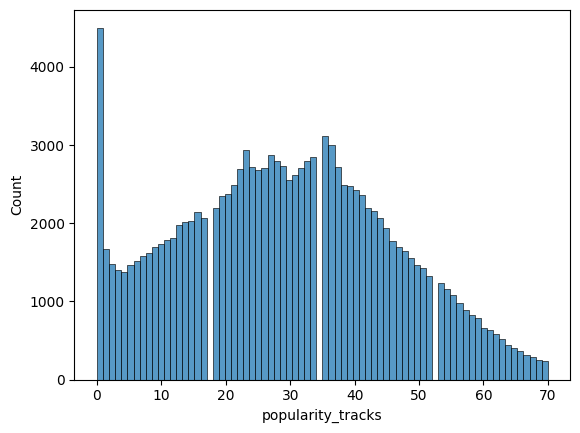

In [ ]:
sns.histplot(dataset.loc[dataset_features_test.index], x="popularity_tracks")

###Baseline (no resampling)

For our control, we will perform no undersampling of majority class(s) nor oversampling. But we will train multiple balanced Random Forest Classifiers to handle the class imbalance

In [ ]:
rfc_baseline = sklearn.ensemble.RandomForestClassifier(oob_score=True)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop = 20)]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
              "class_weight":["balanced"]
               }
scoring = {'accuracy': sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score),
        'f1': sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average="weighted")}


rf_RandomGrid_baseline = sklearn.model_selection.RandomizedSearchCV(estimator = rfc_baseline, param_distributions = param_grid, cv = 5, verbose=2, n_jobs = 5, scoring=scoring, refit="f1", n_iter=5, error_score="raise")
rf_RandomGrid_baseline.fit(dataset_features_dev, dataset_y_dev)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestClassifier(oob_score=True), n_iter=5,
                   n_jobs=5,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [10, 10, 10, 10, 10, 11,
                                                      11, 11, 11, 11, 12, 12,
                                                      12, 12, 12, 13, 13, 13,
                                                      13, 13, 14, 14, 14, 14,
                                                      14, 15, 15, 15, 15, 15, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [20, 20, 21, 21, 22, 23,
                                                         23, 24, 24, 25, 26, 26,
                                                         27, 27, 28, 29, 29, 30,
                                                         31, 31, 32, 32, 33, 34,
                                                         34, 35, 35, 36, 37, 37, ...]},
                   refit='f1',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1': make_scorer(f1_score, average=weighted)},
                   verbose=2)

In [ ]:
dump(rf_RandomGrid_baseline.best_estimator_, os.path.join(model_destination, 'random_forest_classifier_baseline.joblib'))

In [ ]:
baseline_rclf = load(os.path.join(model_destination, 'random_forest_classifier_baseline.joblib'))
baseline_rclf.oob_score_

0.09541449739687625

In [ ]:
print("Testing Accuracy=", sklearn.metrics.accuracy_score(dataset_y_test, baseline_rclf.predict(dataset_features_test)))
print("Testing F1 score(weighted)=", sklearn.metrics.f1_score(dataset_y_test, baseline_rclf.predict(dataset_features_test), average="weighted"))

Testing Accuracy= 0.09524365743120124
Testing F1 score(weighted)= 0.09529348862530565


[Text(0.5, 1.0, 'Baseline Random Forest: Feature Importances vs Features')]

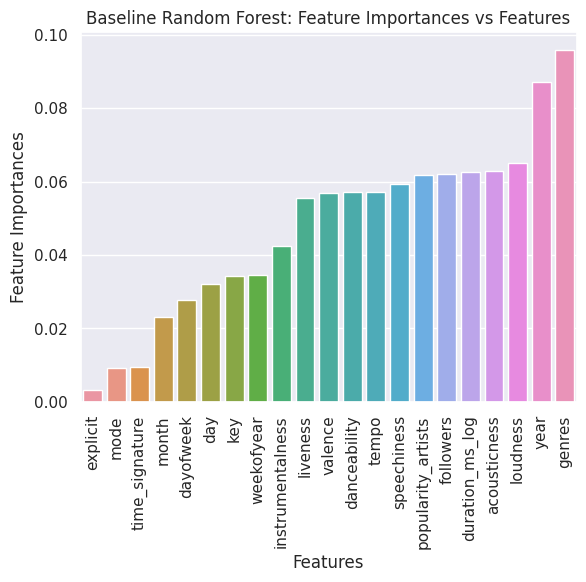

In [ ]:
feature_imp = pd.DataFrame({'Feature Importances':baseline_rclf.feature_importances_,'Features':dataset_features_test.columns})
sns.set(font_scale = 1)
plt.xticks(rotation=90)
sns.barplot(y="Feature Importances", x="Features", data=feature_imp.sort_values(by="Feature Importances", 
                                                    ascending=True)).set(title='Baseline Random Forest: Feature Importances vs Features')

###SMOTE
The below figure shows the large occurrance of "0" for popularity track. This can cause issues where the model is bias towards the high presence of one particular class. We also don't really know if the 0 popularity is combination of garbage data + actual real data!.

The plan for SMOTE is to first  randomly downsample the "0" class till it has 7000 records, and then apply SMOTE to upsample the rest of minority classes. This way we can also prevent our dataset from increases drastically in size as well.

<Axes: xlabel='popularity_tracks', ylabel='Count'>

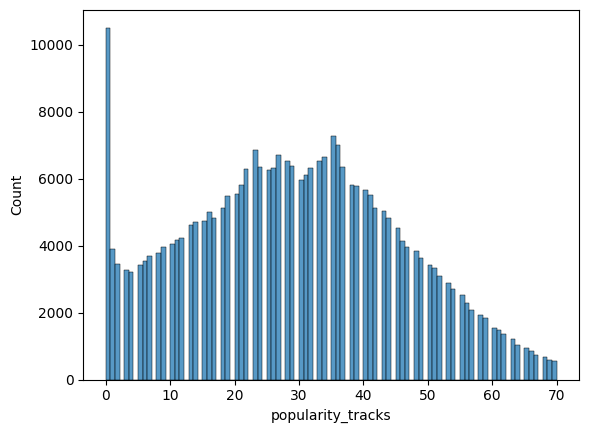

In [ ]:
sns.histplot(dataset.loc[dataset_features_dev.index], x="popularity_tracks")

After some initial class filtering, we have 70 classes but the dataset is not balanced. Due to the right skew of the distribution, lets try some undersampling and SMOTE to balance the dev dataset

In [23]:
#Lets try to downsample the 0 class since otherwise SMOTE would blow up the number of rows we have
undersampler = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={0:7000})
dataset_features_dev_over, dataset_y_dev_over = undersampler.fit_resample(dataset_features_dev, dataset_y_dev)

<Axes: xlabel='popularity_tracks', ylabel='Count'>

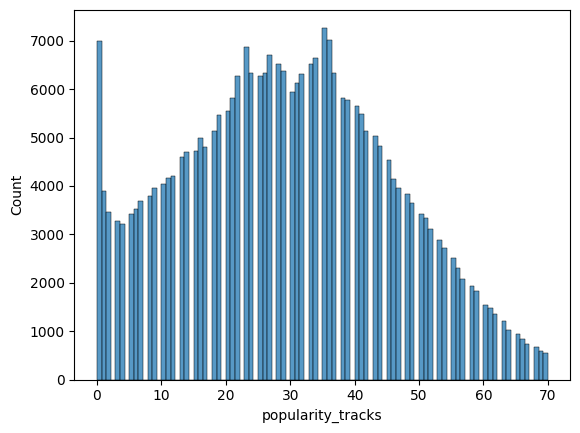

In [ ]:
sns.histplot(dataset_y_dev_over)

In [24]:
#Use SMOTE to oversample the minority classes
smote = imblearn.over_sampling.SMOTE()
dataset_features_dev_over, dataset_y_dev_over = smote.fit_resample(dataset_features_dev_over, dataset_y_dev_over)

<Axes: xlabel='popularity_tracks', ylabel='Count'>

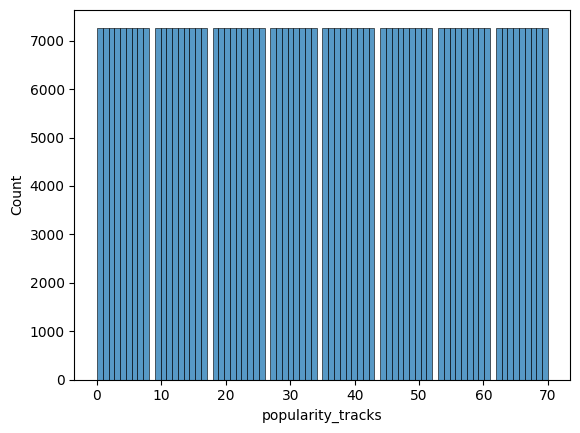

In [ ]:
sns.histplot(dataset_y_dev_over)

In [14]:
print("Before:", dataset_features_dev.shape)
print("After:", dataset_features_dev_over.shape)

Before: (299640, 22)
After: (516312, 22)


In [ ]:
rfc_smote = sklearn.ensemble.RandomForestClassifier(oob_score=True)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop = 20)]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               }
#scoring=["roc_auc", "average_precision", "accuracy", "f1"]
scoring = {'accuracy': sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score),
        'f1': sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average="weighted")}


rf_RandomGrid_smote = sklearn.model_selection.RandomizedSearchCV(estimator = rfc_smote, param_distributions = param_grid, cv = 5, verbose=2, n_jobs = 5, scoring=scoring, refit="f1", n_iter=5, error_score="raise")
rf_RandomGrid_smote.fit(dataset_features_dev_over, dataset_y_dev_over)


dump(rf_RandomGrid_smote.best_estimator_, os.path.join(model_destination, 'random_forest_classifier_smote.joblib'))

In [25]:
smote_rclf = load(os.path.join(model_destination, 'random_forest_classifier_smote_VG.joblib'))
smote_rclf.oob_score_

0.21335549047862531

In [26]:
print("Testing Accuracy=", sklearn.metrics.accuracy_score(dataset_y_test, smote_rclf.predict(dataset_features_test)))
print("Testing F1 score(weighted)=", sklearn.metrics.f1_score(dataset_y_test, smote_rclf.predict(dataset_features_test), average="weighted"))

Testing Accuracy= 0.4853680948153686
Testing F1 score(weighted)= 0.4864433341820426


[Text(0.5, 1.0, 'SMOTE with Undersampling Random Forest: Feature Importances vs Features')]

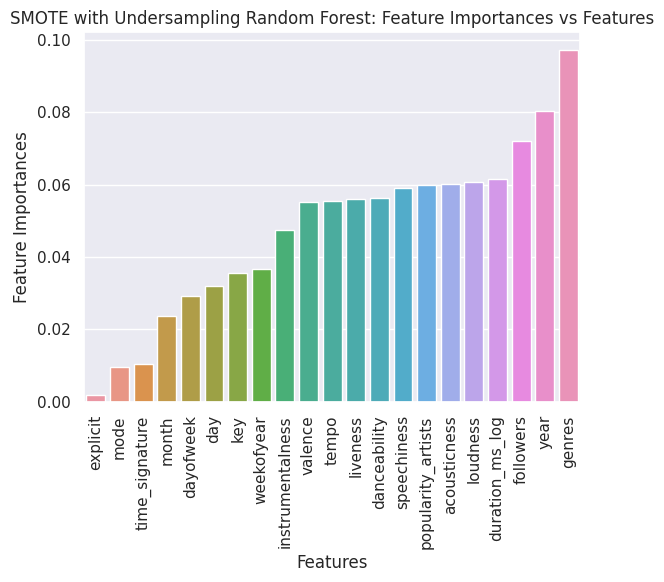

In [ ]:
feature_imp = pd.DataFrame({'Feature Importances':smote_rclf.feature_importances_,'Features':dataset_features_test.columns})
sns.set(font_scale = 1)
plt.xticks(rotation=90)
sns.barplot(y="Feature Importances", x="Features", data=feature_imp.sort_values(by="Feature Importances", 
                                                    ascending=True)).set(title='SMOTE with Undersampling Random Forest: Feature Importances vs Features')